In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from array import array
import time
import scipy.stats as st
import seaborn as sns
import pandas as pd
import math
import pickle

In [13]:
from TypicalMH import MH 
from TypicalMH import APMHT
from TypicalMH import Conf 
from TypicalMH import MiniMH

In [14]:

#proir function
def pior(theta,p_mu=1,p_sigma=1):
    return st.norm.pdf(theta,p_mu,p_sigma)
def logpior(theta,p_mu=1,p_sigma=1):
    return np.log(st.norm.pdf(theta,p_mu,p_sigma))
def lik(i,z,theta):
    return st.norm.pdf(z[i],theta,1)
def loglik(i,z,theta):
    return np.log(st.norm.pdf(z[i],theta,1))

In [15]:
#parameters
n=10000
l_mu=[1]
T=100
ep=0.05
m=100

theta_ini=l_mu


In [16]:
#data
z=np.random.normal(1, 1, n)
x=z.reshape((n,1))

MH

In [17]:
tn=MH(z,T,l_mu,logpior,loglik)

0.11163735389709473


APMHT

In [18]:
tnA,nleA=APMHT(z, T, ep, m, theta_ini,logpior,loglik)

0.07471704483032227
10200


Confidence Sampler

In [19]:
tnC,nleC=Conf(z,T,m,theta_ini,logpior,loglik)

0.48091793060302734
982400.0


Minibatch MH

In [20]:
tnM,nleM=MiniMH(z,T,m,theta_ini,logpior,loglik)

1.334259033203125
full_N_time: 6
num_Xc: 94


PMMIN

In [21]:
from PMMINMethod import clustering 
from PMMINMethod import generateB
from PMMINMethod import PMMIN 


In [22]:
#一维正态分布
def piorN(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为0.3的正态分布
    return st.norm.pdf(theta,p_mu,p_sigma)
def logpriorN(theta,p_mu=1,p_sigma=1):
    #先验分布 均值为1 方差为0.3的正态分布取对数
    return np.log(st.norm.pdf(theta,p_mu,p_sigma))

def likN(z,theta):
    #似然函数为均值为theta，方差为1的正态分布
    #对z的每一行计算正态分布的密度函数，相当于计算每一个样本点d维的似然
    #z的尺寸为n*d 返回值为n*d
    return st.norm.pdf(z,theta,1)

def loglikN(z,theta):
    #对z的第i行计算正态分布的密度函数取对数
    return np.log(st.norm.pdf(z,theta,1))

def gradient_llik(z,theta):
    #计算对数似然函数的梯度
    return -(z-theta)

def hessian_llik(z,theta):
    if len(z.shape)<=1:
        return -1*np.ones((z.shape[0],1))
    return -1*np.ones((z.shape[0],z.shape[1]))

In [23]:
outk,outz,C=clustering(x,0.05)
data=x
B=generateB(data,outk,outz,C)

In [24]:
m=100
tnP=PMMIN(x,outz,outk,C,m,T, l_mu ,B, logpriorN,loglikN,gradient_llik,hessian_llik)

8.610969066619873


plot

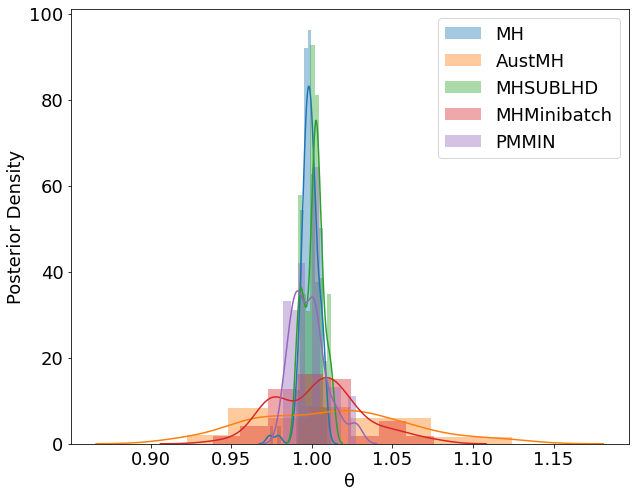

In [25]:
# Histograms for each gender

plt.figure(figsize=(10, 8))
sns.distplot(a=tn, label="MH", kde=True)
sns.distplot(a=tnA, label="AustMH", kde=True)
sns.distplot(a=tnC, label="MHSUBLHD", kde=True)
sns.distplot(a=tnM, label="MHMinibatch", kde=True)
sns.distplot(a=tnP, label="PMMIN", kde=True)

plt.xticks(size=18)
plt.ylabel('Posterior Density',fontsize=18)
plt.yticks(size=18)
plt.xlabel('θ',fontsize=18)
# Add title
#plt.title('Posterior Distribution',size=18)
# Force legend to appear
plt.legend(fontsize=18)
#sns.distplot(a=tn.transpose()[40001:50001,:], kde=False)
#sns.distplot(z, kde=False)
#sns.distplot(a=bayes, kde=False)

# Test

There is one example of the samples generating by APMHT.
We show how to calculate the hellinger distance, the geweke test and the ESS.
And nle means the number of subsampling.

In [26]:
import warnings
warnings.filterwarnings('ignore')
import rpy2
import rpy2.ipython
from rpy2 import robjects

In [33]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [34]:
%%R
require(mvtnorm)
require(coda)
require(ggplot2)
require(ggpubr)
require(rootSolve)
require(plyr)
require(pracma)

In [29]:
realmh=MH(z,10000,l_mu,logpior,loglik)

10.534502983093262


In [41]:
%%R -i realmh,tnA

statip::hellinger(realmh,tnA)

[1] 0.5636513


In [42]:

%%R -i tnP
a<-as.mcmc(tnA)
a<-as.numeric(a)
effectiveSize(a)
geweke.diag(a,frac1=0.3, frac2=0.7)


Fraction in 1st window = 0.3
Fraction in 2nd window = 0.7 

 var1 
-0.72 



In [43]:
#ESS
robjects.r('a<-as.mcmc(tnA)')
robjects.r('coda::effectiveSize(a<-as.numeric(a))')

14.786310


In [39]:
nle5=0
nle=0
for i in range(5):
    tnA,nle=APMHT(z, T, ep, m, theta_ini,logpior,loglik)
    nle5+=nle

0.08683371543884277
10900
0.06023979187011719
10200
0.06499052047729492
10700
0.0650637149810791
11300
0.0747988224029541
11000


In [40]:
nleA=nle5/5